# Fraud Classification - Prepare training data and train Machine Learning model
<BR><BR>The purpose of this notebook is to prepare the training dataset with potential features and to train a Machine Learning model that can predict a fraud transaction.

### Steps in this notebook
-  Connect to SAP HANA
-  Create a SAP HANA DataFrame which points to the data
-  Prepare a training dataset with additional features that could predict fraud like customer, merchant, card details, etc.
-  Train and improve a Machine Learning model
-  Carry out an error analysis to understand in which areas the model performed better or worse.

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/319d36de4fd64ac3afbf91b1fb3ce8de/cloud/en-US
-  SAP HANA Automated Predictive Library (APL):
   https://help.sap.com/viewer/product/apl/2018/en-US

### Create a SAP HANA DataFrame, which points to the training data
Instantiate a connecton object to SAP HANA.
-  For simplicity, to help you get started, these values are hardcoded here. 
-  We recommend keeping these credentials in the Secure User Store of the SAP HANA Client. Retrieving the credentials from the Secure User Store prevents having to specify these credentials in clear text. See the blog on the SAP Commmunity to which these notebooks belong, for steps on how to use that Secure User Store.

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(key = 'NA_POC_HANA_CLOUD', encrypt = 'true',sslValidateCertificate = 'false')

Create the SAP HANA DataFrame, which points to the view with historic sales. No data is extracted.

In [2]:
df_pushdown = conn.table(table = 'CARD_TRANSACTIONS_JULY_2020', schema = 'BIUSER')

### Map the transaction data with additional customer, merchant, card and weather details
The card transactions dataset can be mapped to customer (using CT_CUST_ID), merchant (CT_MER_ID), card (CT_CARD_ID), and weather (based on the merchant location)

In [3]:
df_pushdown.head(5).collect()

,CT_ID,CT_DATE,CT_CARD_ID,CT_CUST_ID,CT_MER_ID,CT_AMOUNT,CT_FEE,CT_FLAG_FRAUD,CT_STATUS,CT_DAYDATE
0,129814245,2020-07-01 05:09:28,184460,184460,6927,20.19,0.21,1,1,2020-07-01
1,129818127,2020-07-01 08:10:08,198835,198835,7011,20.28,0.21,0,1,2020-07-01
2,129861468,2020-07-01 22:52:11,212806,212806,5209,19.66,0.21,0,1,2020-07-01
3,129857633,2020-07-01 21:10:11,191057,191057,6059,20.13,0.21,0,1,2020-07-01
4,129856028,2020-07-01 20:53:39,101379,101379,7010,20.18,0.21,0,1,2020-07-01


#### Time based features

In [4]:
df_time = conn.sql("select CT_ID, CT_FLAG_FRAUD, CT_AMOUNT, CT_FEE, hour(CT_DATE) as HOUR_TXN, weekday(CT_DATE) as WEEKDAY_TXN from BIUSER.CARD_TRANSACTIONS_JULY_2020 t")

In [5]:
df_time.head(5).collect()

,CT_ID,CT_FLAG_FRAUD,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN
0,129814245,1,20.19,0.21,5,2
1,129818127,0,20.28,0.21,8,2
2,129861468,0,19.66,0.21,22,2
3,129857633,0,20.13,0.21,21,2
4,129856028,0,20.18,0.21,20,2


In [6]:
df_time.count()

1689500

#### Customer based features

In [7]:
df_avg_spend_2020 = conn.sql("select CT_ID, \
                             case when c.AVG_SPEND_2020 = 0 then 0 else round(t.CT_AMOUNT / c.AVG_SPEND_2020, 2) end as RATIO_AMOUNT_AVG_SPEND_2020 \
                             from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, \
                             ( select CT_CUST_ID, avg(CT_AMOUNT) as AVG_SPEND_2020 from SOURCEDATA.VT_CARD_TRANSACTIONS \
                                where CT_DATE < '2020-07-01' \
                                group by CT_CUST_ID ) c \
                             where t.CT_CUST_ID = c.CT_CUST_ID")

In [8]:
df_avg_spend_2020.head(5).collect()

,CT_ID,RATIO_AMOUNT_AVG_SPEND_2020
0,129814245,0.15
1,129818127,0.18
2,129861468,0.26
3,129857633,0.19
4,129856028,0.12


In [9]:
df_customer_ratios = conn.sql("select CT_ID, \
                     case when c.CUST_AVG_SPEND = 0 then 0 else round(t.CT_AMOUNT / c.CUST_AVG_SPEND, 2) end as RATIO_AMOUNT_AVG_SPEND, \
                     case when c.CUST_LIFE_SPEND = 0 then 0 else round(t.CT_AMOUNT / c.CUST_LIFE_SPEND, 2) end as RATIO_AMOUNT_LIFE_SPEND, \
                     case when c.CUST_INCOME = 0 then 0 else round(t.CT_AMOUNT / c.CUST_INCOME, 2) end as RATIO_AMOUNT_INCOME \
                     from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.CUSTOMER c \
                     where t.CT_CUST_ID = c.CUST_ID")

In [10]:
df_customer_ratios.head(5).collect()

,CT_ID,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME
0,129814245,0.0,0.0,0.0
1,129818127,0.0,0.0,0.0
2,129861468,0.0,0.0,0.0
3,129857633,0.0,0.0,0.0
4,129856028,0.0,0.0,0.0


#### Card based features

In [11]:
df_card_features = conn.sql("select CT_ID, CARD_INTERNATIONAL, \
                    case when c.CARD_LIMIT = 0 then 0 else round(t.CT_AMOUNT / c.CARD_LIMIT, 2) end as RATIO_AMOUNT_LIMIT \
                    from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.CARD c \
                    where t.CT_CUST_ID = c.CARD_ID")

In [12]:
df_card_features.head(5).collect()

,CT_ID,CARD_INTERNATIONAL,RATIO_AMOUNT_LIMIT
0,131183206,0,0
1,129922487,0,0
2,130390992,0,0
3,130760389,0,0
4,130613901,0,0


In [14]:
df_card_features.count()

1689500

#### Merchant based features

In [15]:
df_merchant_features = conn.sql("select CT_ID, MER_SEGMENT, MER_FLAG_VIRTUAL_STORE \
                                from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm \
                                where t.CT_MER_ID = tm.MER_ID")

In [16]:
df_merchant_features.head(5).collect()

,CT_ID,MER_SEGMENT,MER_FLAG_VIRTUAL_STORE
0,129814245,2,0
1,129818127,2,1
2,129861468,2,0
3,129857633,1,1
4,129856028,3,0


In [17]:
df_new_merchant_store = conn.sql("select CT_ID, 1 as FLAG_NEW_MERCHANT_STORE \
                        from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm \
                        where t.CT_MER_ID = tm.MER_ID and tm.MER_FLAG_VIRTUAL_STORE not in \
                        (   select distinct MER_FLAG_VIRTUAL_STORE as CUST_MERCHANTS \
                            from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                            where c.CT_DATE < '2020-07-01' \
                            and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID ) \
                        union all \
                        select CT_ID, 0 as FLAG_NEW_MERCHANT_STORE \
                        from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm \
                        where t.CT_MER_ID = tm.MER_ID and tm.MER_FLAG_VIRTUAL_STORE in \
                        (   select distinct MER_FLAG_VIRTUAL_STORE as CUST_MERCHANTS \
                            from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                            where c.CT_DATE < '2020-07-01' \
                            and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID)")

In [18]:
df_new_merchant_store.head(5).collect()

,CT_ID,FLAG_NEW_MERCHANT_STORE
0,131362914,1
1,131346952,1
2,131339279,1
3,131352482,1
4,131348120,1


In [19]:
df_new_merchant_segment = conn.sql("select CT_ID, 1 as FLAG_NEW_MERCHANT_SEGMENT \
                                    from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm \
                                    where t.CT_MER_ID = tm.MER_ID and tm.MER_SEGMENT not in \
                                    (    select distinct MER_SEGMENT as CUST_MERCHANTS \
                                         from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                                         where c.CT_DATE < '2020-07-01' \
                                         and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID ) \
                                    union all \
                                    select CT_ID, 0 as FLAG_NEW_MERCHANT_SEGMENT \
                                    from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm \
                                    where t.CT_MER_ID = tm.MER_ID and tm.MER_SEGMENT in \
                                    (    select distinct MER_SEGMENT as CUST_MERCHANTS \
                                         from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                                         where c.CT_DATE < '2020-07-01' \
                                         and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID)")

In [20]:
df_new_merchant_segment.head(5).collect()

,CT_ID,FLAG_NEW_MERCHANT_SEGMENT
0,130965068,1
1,130019146,1
2,131103404,1
3,131340881,1
4,131341833,1


#### Weather based features

In [21]:
df_weather = conn.sql("select CT_ID, \
avg_air_temperature_daily, \
avg_air_temp_7_days, \
avg_relative_humidity_daily, \
avg_relative_humidity_7_days, \
avg_wind_speed_daily, \
avg_wind_speed_7_days \
from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm, \
(	select weather_date, county, \
	avg_precipitation_daily, \
	avg(avg_precipitation_daily) over (partition by county order by weather_date rows 6 preceding ) avg_precipitation_7_days, \
	avg_air_temperature_daily, \
	avg(avg_air_temperature_daily) over (partition by county order by weather_date rows 6 preceding ) avg_air_temp_7_days, \
	avg_relative_humidity_daily, \
	avg(avg_relative_humidity_daily) over (partition by county order by weather_date rows 6 preceding ) avg_relative_humidity_7_days, \
	avg_wind_speed_daily, \
	avg(avg_wind_speed_daily) over (partition by county order by weather_date rows 6 preceding ) avg_wind_speed_7_days from ( \
               select datetime_date weather_date, \
               county, \
               avg(precipitation) avg_precipitation_daily, \
               avg(air_temperature) avg_air_temperature_daily, \
               avg(relative_humidity)  avg_relative_humidity_daily, \
               avg(wind_speed) avg_wind_speed_daily \
               from SOURCEDATA.VT_CA_WEATHER_SENSOR_DAILY a \
               join SOURCEDATA.VT_WEATHER_STATIONS b on a.station_id = b.\"Station Number\" \
               group by datetime_date, county \
               order by 1,2 ) ) w \
where t.CT_MER_ID = tm.MER_ID and \
tm.COUNTY = w.COUNTY and \
t.CT_DAYDATE = w.WEATHER_DATE")

In [22]:
df_weather.count()

1498273

In [23]:
df_weather.head(5).collect()

,CT_ID,AVG_AIR_TEMPERATURE_DAILY,AVG_AIR_TEMP_7_DAYS,AVG_RELATIVE_HUMIDITY_DAILY,AVG_RELATIVE_HUMIDITY_7_DAYS,AVG_WIND_SPEED_DAILY,AVG_WIND_SPEED_7_DAYS
0,130063937,82.17,77.83,37.11,39.55,3.73,4.86
1,130178502,77.91,79.48,37.94,37.83,4.34,4.73
2,130242890,78.66,79.41,39.02,38.32,3.93,4.35
3,129917421,76.64,79.48,39.95,40.31,6.67,5.95
4,131494518,83.04,83.33,40.89,40.49,3.87,4.09


### Join datasets to combine all features
Join the data frames to combine time, customer, merchant, card, and weather features.

In [24]:
df_time_avgspend = df_time.alias('T').join(df_avg_spend_2020.alias('A'), 'T.CT_ID = A.CT_ID', 
                                           select = [('T.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 'RATIO_AMOUNT_AVG_SPEND_2020', 'CT_FLAG_FRAUD'])

In [25]:
df_time_avgspend.head(5).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,CT_FLAG_FRAUD
0,129814245,20.19,0.21,5,2,0.15,1
1,129818127,20.28,0.21,8,2,0.18,0
2,129861468,19.66,0.21,22,2,0.26,0
3,129857633,20.13,0.21,21,2,0.19,0
4,129856028,20.18,0.21,20,2,0.12,0


In [26]:
df_ta_customer = df_time_avgspend.alias('TA').join(df_customer_ratios.alias('C'), 'TA.CT_ID = C.CT_ID',
                                                   select = [('TA.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 'RATIO_AMOUNT_INCOME', 'CT_FLAG_FRAUD'])

In [27]:
df_ta_customer.head(5).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,CT_FLAG_FRAUD
0,129814245,20.19,0.21,5,2,0.15,0.0,0.0,0.0,1
1,129818127,20.28,0.21,8,2,0.18,0.0,0.0,0.0,0
2,129861468,19.66,0.21,22,2,0.26,0.0,0.0,0.0,0
3,129857633,20.13,0.21,21,2,0.19,0.0,0.0,0.0,0
4,129856028,20.18,0.21,20,2,0.12,0.0,0.0,0.0,0


In [28]:
df_tac_card = df_ta_customer.alias('TAC').join(df_card_features.alias('CA'), 'TAC.CT_ID = CA.CT_ID',
                                              select = [('TAC.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'CT_FLAG_FRAUD'])

In [29]:
df_tac_card.head(5).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,CARD_INTERNATIONAL,RATIO_AMOUNT_LIMIT,CT_FLAG_FRAUD
0,129814245,20.19,0.21,5,2,0.15,0.0,0.0,0.0,0,0,1
1,129818127,20.28,0.21,8,2,0.18,0.0,0.0,0.0,0,0,0
2,129861468,19.66,0.21,22,2,0.26,0.0,0.0,0.0,0,0,0
3,129857633,20.13,0.21,21,2,0.19,0.0,0.0,0.0,0,0.01,0
4,129856028,20.18,0.21,20,2,0.12,0.0,0.0,0.0,0,0,0


In [30]:
df_tacc_merchant = df_tac_card.alias('TACC').join(df_merchant_features.alias('M'), 'TACC.CT_ID = M.CT_ID',
                                              select = [('TACC.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'CT_FLAG_FRAUD'])

In [31]:
df_tacc_merchant.head(5).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,CARD_INTERNATIONAL,RATIO_AMOUNT_LIMIT,MER_SEGMENT,MER_FLAG_VIRTUAL_STORE,CT_FLAG_FRAUD
0,129814245,20.19,0.21,5,2,0.15,0.0,0.0,0.0,0,0,2,0,1
1,129818127,20.28,0.21,8,2,0.18,0.0,0.0,0.0,0,0,2,1,0
2,129861468,19.66,0.21,22,2,0.26,0.0,0.0,0.0,0,0,2,0,0
3,129857633,20.13,0.21,21,2,0.19,0.0,0.0,0.0,0,0.01,1,1,0
4,129856028,20.18,0.21,20,2,0.12,0.0,0.0,0.0,0,0,3,0,0


In [32]:
df_taccm_ns = df_tacc_merchant.alias('TACCM').join(df_new_merchant_store.alias('NS'), 'TACCM.CT_ID = NS.CT_ID',
                                              select = [('TACCM.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'FLAG_NEW_MERCHANT_STORE',
                                                        'CT_FLAG_FRAUD'])

In [33]:
df_taccm_ns.head(5).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,CARD_INTERNATIONAL,RATIO_AMOUNT_LIMIT,MER_SEGMENT,MER_FLAG_VIRTUAL_STORE,FLAG_NEW_MERCHANT_STORE,CT_FLAG_FRAUD
0,129814245,20.19,0.21,5,2,0.15,0.0,0.0,0.0,0,0,2,0,0,1
1,129818127,20.28,0.21,8,2,0.18,0.0,0.0,0.0,0,0,2,1,0,0
2,129861468,19.66,0.21,22,2,0.26,0.0,0.0,0.0,0,0,2,0,0,0
3,129857633,20.13,0.21,21,2,0.19,0.0,0.0,0.0,0,0.01,1,1,0,0
4,129856028,20.18,0.21,20,2,0.12,0.0,0.0,0.0,0,0,3,0,0,0


In [34]:
df_taccmn_s = df_taccm_ns.alias('TACCMN').join(df_new_merchant_segment.alias('S'), 'TACCMN.CT_ID = S.CT_ID',
                                              select = [('TACCMN.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'FLAG_NEW_MERCHANT_STORE', 'FLAG_NEW_MERCHANT_SEGMENT',
                                                        'CT_FLAG_FRAUD'])

In [35]:
df_taccmn_s.head(5).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,CARD_INTERNATIONAL,RATIO_AMOUNT_LIMIT,MER_SEGMENT,MER_FLAG_VIRTUAL_STORE,FLAG_NEW_MERCHANT_STORE,FLAG_NEW_MERCHANT_SEGMENT,CT_FLAG_FRAUD
0,129814245,20.19,0.21,5,2,0.15,0.0,0.0,0.0,0,0,2,0,0,0,1
1,129818127,20.28,0.21,8,2,0.18,0.0,0.0,0.0,0,0,2,1,0,0,0
2,129861468,19.66,0.21,22,2,0.26,0.0,0.0,0.0,0,0,2,0,0,0,0
3,129857633,20.13,0.21,21,2,0.19,0.0,0.0,0.0,0,0.01,1,1,0,0,0
4,129856028,20.18,0.21,20,2,0.12,0.0,0.0,0.0,0,0,3,0,0,0,0


In [36]:
df_final = df_taccmn_s.alias('TACCMNS').join(df_weather.alias('W'), 'TACCMNS.CT_ID = W.CT_ID',
                                              select = [('TACCMNS.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'FLAG_NEW_MERCHANT_STORE', 'FLAG_NEW_MERCHANT_SEGMENT',
                                                        'AVG_AIR_TEMPERATURE_DAILY', 'AVG_AIR_TEMP_7_DAYS', 
                                                        'AVG_RELATIVE_HUMIDITY_DAILY', 'AVG_RELATIVE_HUMIDITY_7_DAYS',
                                                        'AVG_WIND_SPEED_DAILY', 'AVG_WIND_SPEED_7_DAYS',
                                                        'CT_FLAG_FRAUD'])

In [37]:
df_final.count()

1498273

In [38]:
df_final.head(5).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,CARD_INTERNATIONAL,...,MER_FLAG_VIRTUAL_STORE,FLAG_NEW_MERCHANT_STORE,FLAG_NEW_MERCHANT_SEGMENT,AVG_AIR_TEMPERATURE_DAILY,AVG_AIR_TEMP_7_DAYS,AVG_RELATIVE_HUMIDITY_DAILY,AVG_RELATIVE_HUMIDITY_7_DAYS,AVG_WIND_SPEED_DAILY,AVG_WIND_SPEED_7_DAYS,CT_FLAG_FRAUD
0,130950717,21.14,0.43,22,1,0.33,0.0,0.0,0.0,0,...,1,1,0,60.69,61.36,80.95,79.21,4.08,4.28,1
1,130935148,21.17,0.22,17,1,0.11,0.0,0.0,0.0,0,...,1,1,0,74.41,74.7,59.39,55.12,4.68,4.94,1
2,130611065,17.13,0.18,18,2,0.02,0.0,0.0,0.0,1,...,1,1,1,64.74,67.81,81.68,75.83,3.65,3.51,1
3,131224988,17.13,0.18,22,6,0.6,0.0,0.0,0.0,0,...,1,1,0,63.37,64.19,82.06,81.13,3.35,3.57,1
4,129918382,17.13,0.18,23,3,0.12,0.0,0.0,0.0,1,...,1,1,0,68.61,73.32,40,49.7,5.61,6.12,1


In [39]:
df_final.select_statement

'SELECT TACCMNS.CT_ID AS "CT_ID", "CT_AMOUNT", "CT_FEE", "HOUR_TXN", "WEEKDAY_TXN", "RATIO_AMOUNT_AVG_SPEND_2020", "RATIO_AMOUNT_AVG_SPEND", "RATIO_AMOUNT_LIFE_SPEND", "RATIO_AMOUNT_INCOME", "CARD_INTERNATIONAL", "RATIO_AMOUNT_LIMIT", "MER_SEGMENT", "MER_FLAG_VIRTUAL_STORE", "FLAG_NEW_MERCHANT_STORE", "FLAG_NEW_MERCHANT_SEGMENT", "AVG_AIR_TEMPERATURE_DAILY", "AVG_AIR_TEMP_7_DAYS", "AVG_RELATIVE_HUMIDITY_DAILY", "AVG_RELATIVE_HUMIDITY_7_DAYS", "AVG_WIND_SPEED_DAILY", "AVG_WIND_SPEED_7_DAYS", "CT_FLAG_FRAUD" FROM (SELECT TACCMN.CT_ID AS "CT_ID", "CT_AMOUNT", "CT_FEE", "HOUR_TXN", "WEEKDAY_TXN", "RATIO_AMOUNT_AVG_SPEND_2020", "RATIO_AMOUNT_AVG_SPEND", "RATIO_AMOUNT_LIFE_SPEND", "RATIO_AMOUNT_INCOME", "CARD_INTERNATIONAL", "RATIO_AMOUNT_LIMIT", "MER_SEGMENT", "MER_FLAG_VIRTUAL_STORE", "FLAG_NEW_MERCHANT_STORE", "FLAG_NEW_MERCHANT_SEGMENT", "CT_FLAG_FRAUD" FROM (SELECT TACCM.CT_ID AS "CT_ID", "CT_AMOUNT", "CT_FEE", "HOUR_TXN", "WEEKDAY_TXN", "RATIO_AMOUNT_AVG_SPEND_2020", "RATIO_AMOUNT_AVG_

In [40]:
total_count = df_final.count()
df_pushdown_col_frequency = df_final.agg([('count', 'CT_FLAG_FRAUD', 'COUNT')],  group_by = 'CT_FLAG_FRAUD')
df_col_frequency = df_pushdown_col_frequency.sort('COUNT', desc = True).collect()
df_col_frequency['PERCENT'] = round(df_col_frequency['COUNT'] / total_count, 2)
df_col_frequency.style.format({'COUNT':'{0:,.0f}', 'PERCENT':'{0:,.1%}'}).hide_index() 

CT_FLAG_FRAUD,COUNT,PERCENT
0,"1,350,308",90.0%
1,"147,965",10.0%


### Train APL (Automated Predictive Library) Classification model
Train an APL model to detect fraud

In [41]:
from hana_ml.algorithms.apl.gradient_boosting_classification import GradientBoostingBinaryClassifier
gbapl_model = GradientBoostingBinaryClassifier()

We can define the target and ID columns, and get the remaining features as the predictors.

In [42]:
col_target = 'CT_FLAG_FRAUD'
target_value = '1'

In [43]:
col_id = 'CT_ID'

In [44]:
col_predictors = df_final.columns
col_predictors.remove(col_target)
col_predictors.remove(col_id)
col_predictors

['CT_AMOUNT',
 'CT_FEE',
 'HOUR_TXN',
 'WEEKDAY_TXN',
 'RATIO_AMOUNT_AVG_SPEND_2020',
 'RATIO_AMOUNT_AVG_SPEND',
 'RATIO_AMOUNT_LIFE_SPEND',
 'RATIO_AMOUNT_INCOME',
 'CARD_INTERNATIONAL',
 'RATIO_AMOUNT_LIMIT',
 'MER_SEGMENT',
 'MER_FLAG_VIRTUAL_STORE',
 'FLAG_NEW_MERCHANT_STORE',
 'FLAG_NEW_MERCHANT_SEGMENT',
 'AVG_AIR_TEMPERATURE_DAILY',
 'AVG_AIR_TEMP_7_DAYS',
 'AVG_RELATIVE_HUMIDITY_DAILY',
 'AVG_RELATIVE_HUMIDITY_7_DAYS',
 'AVG_WIND_SPEED_DAILY',
 'AVG_WIND_SPEED_7_DAYS']

We can set the target value (1) that the model will predict, and set other model specific parameters like evaluation metrics (Area Under the Curve), variable auto selection to reduce the number of features that are used in the final model, etc.

In [45]:
gbapl_model.set_params(target_key = target_value) # The behaviour the model will predict
gbapl_model.set_params(eval_metric = 'AUC') # Metric used to evaluate the model performance
gbapl_model.set_params(cutting_strategy = 'random with no test') # Internal splitting strategy
# Activate automatic variable selection and automatic consideration of interactions:
gbapl_model.set_params(other_train_apl_aliases={'APL/VariableAutoSelection': 'true', 
                                                'APL/Interactions': 'true', 
                                                'APL/InteractionsMaxKept': '10'})

Finally, let's fit the Gradient Boosting Binary Classifier on the 1.5M July 2020 transactions.

This model fit function can run for a while (2-3 minutes) to prepare the df_final dataset and then learn on the 1.5M transactions.

In [46]:
gbapl_model.fit(data = df_final, 
                key = col_id, 
                features = col_predictors, 
                label = col_target)

In [47]:
import pandas as pd
list_performance = gbapl_model.get_performance_metrics()
df_performance = pd.DataFrame(list(list_performance.items()), columns=['METRIC', 'VALUE'])
df_performance.loc[df_performance['METRIC'].isin(['AUC', 'BestIteration'])].style.hide_index()

METRIC,VALUE
AUC,0.796300
BestIteration,100


In [48]:
df_summary = gbapl_model.get_summary().filter("KEY in ('ModelVariableCount', 'ModelSelectedVariableCount', 'ModelRecordCount', 'ModelBuildDate')").collect()
df_summary = df_summary[['KEY','VALUE']]
df_summary['KEY'] = df_summary['KEY'].str.replace('Model', '').str.replace('Selected', 'Selected ')
df_summary['KEY'] = df_summary['KEY'].str.replace('Count', ' Count').str.replace('Date', ' Date')
df_summary.style.hide_index()

KEY,VALUE
Variable Count,22
Selected Variable Count,20
Record Count,1498273
Build Date,2020-09-14 23:01:46


In [49]:
df_excluded = gbapl_model.get_indicators().filter("KEY like 'VariableExclusion%'").collect()
df_excluded = df_excluded[['VARIABLE','VALUE']]
df_excluded.columns = ['Excluded Variable', 'Reason']
df_excluded.style.hide_index()

Excluded Variable,Reason


In [50]:
list_contributions = gbapl_model.get_feature_importances()['ExactSHAP']
df_contribution = pd.DataFrame(list(list_contributions.items()), columns=['VARIABLE', 'CONTRIBUTION'])
df_contribution['CUMULATIVE'] = df_contribution['CONTRIBUTION'].cumsum()
format_dict = {'CONTRIBUTION':'{0:,.2%}','CUMULATIVE':'{0:,.2%}'}
df_contribution.style.format(format_dict).hide_index()

VARIABLE,CONTRIBUTION,CUMULATIVE
RATIO_AMOUNT_AVG_SPEND_2020,26.40%,26.40%
HOUR_TXN,25.40%,51.80%
CARD_INTERNATIONAL,15.49%,67.29%
WEEKDAY_TXN,13.59%,80.89%
MER_FLAG_VIRTUAL_STORE,10.85%,91.74%
FLAG_NEW_MERCHANT_SEGMENT,3.97%,95.71%
RATIO_AMOUNT_AVG_SPEND,2.68%,98.39%
RATIO_AMOUNT_LIFE_SPEND,0.88%,99.27%
RATIO_AMOUNT_LIMIT,0.31%,99.58%
FLAG_NEW_MERCHANT_STORE,0.23%,99.81%


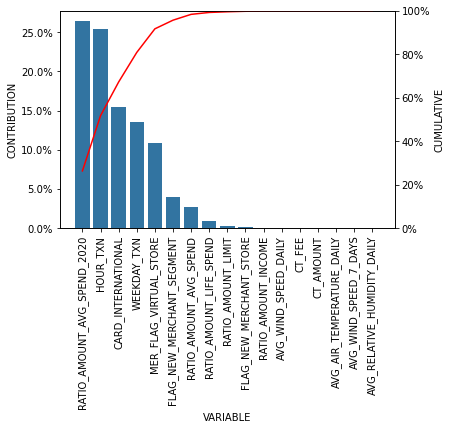

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import PercentFormatter
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
ax2 = ax1.twinx()
sns.barplot(data = df_contribution, 
             x = 'VARIABLE', 
             y = 'CONTRIBUTION',
             color = '#1f77b4',
             ax=ax1)
sns.lineplot(data = df_contribution, sort=False,
             x = 'VARIABLE', 
             y = 'CUMULATIVE',
             color = 'red',
             ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylim(0, 1)
plt.show();

In [52]:
variable_name = 'RATIO_AMOUNT_AVG_SPEND_2020'

df_category_signif = gbapl_model.get_indicators().filter("KEY = 'GroupSignificance' and VARIABLE = '" + variable_name + "'").collect()
df_category_signif = df_category_signif[['VARIABLE', 'TARGET', 'DETAIL', 'VALUE']]
df_category_signif['VALUE'] = df_category_signif['VALUE'].astype(float).round(2)
df_category_signif.columns = ['Predictor', 'Target','Category','Significance']
df_category_signif = df_category_signif.sort_values(by = ['Significance'], ascending = False)

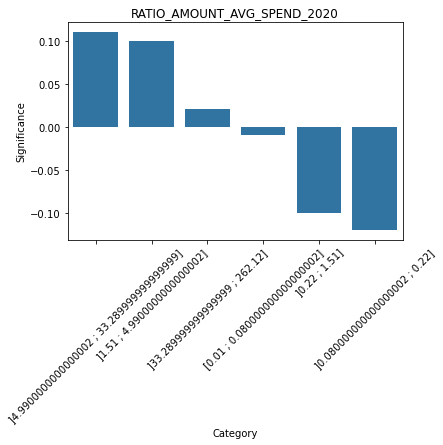

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
bplot = sns.barplot(data = df_category_signif, x = 'Category', y = 'Significance', color = '#1f77b4')
bplot.set_title(variable_name)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 45);

We can check the effect of the HOUR_TXN variable by getting the category significance and plotting it.

In [54]:
variable_name = 'HOUR_TXN'

df_category_signif = gbapl_model.get_indicators().filter("KEY = 'GroupSignificance' and VARIABLE = '" + variable_name + "'").collect()
df_category_signif = df_category_signif[['VARIABLE', 'TARGET', 'DETAIL', 'VALUE']]
df_category_signif['VALUE'] = df_category_signif['VALUE'].astype(float).round(2)
df_category_signif.columns = ['Predictor', 'Target','Category','Significance']
df_category_signif = df_category_signif.sort_values(by = ['Significance'], ascending = False)

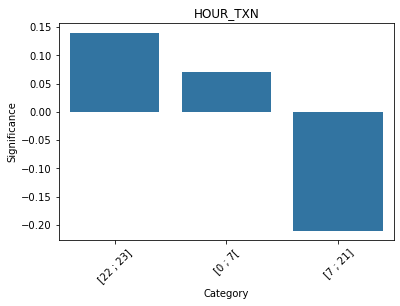

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
bplot = sns.barplot(data = df_category_signif, x = 'Category', y = 'Significance', color = '#1f77b4')
bplot.set_title(variable_name)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 45);

The effect from WEEKDAY_TXN is lower. We can check how the fraud probability varies based on the weekends vs. weekday.

In [56]:
variable_name = 'WEEKDAY_TXN'

df_category_signif = gbapl_model.get_indicators().filter("KEY = 'GroupSignificance' and VARIABLE = '" + variable_name + "'").collect()
df_category_signif = df_category_signif[['VARIABLE', 'TARGET', 'DETAIL', 'VALUE']]
df_category_signif['VALUE'] = df_category_signif['VALUE'].astype(float).round(2)
df_category_signif.columns = ['Predictor', 'Target','Category','Significance']
df_category_signif = df_category_signif.sort_values(by = ['Significance'], ascending = False)

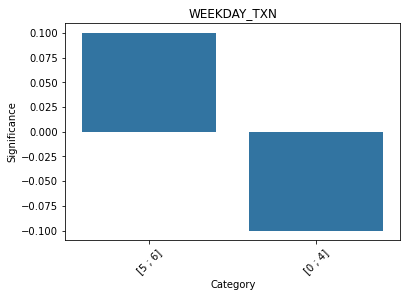

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
bplot = sns.barplot(data = df_category_signif, x = 'Category', y = 'Significance', color = '#1f77b4')
bplot.set_title(variable_name)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 45);

In [58]:
df_correlations = gbapl_model.get_indicators().filter("KEY = 'CorrelatedVariable'").collect()
df_correlations = df_correlations[['VARIABLE', 'DETAIL', 'VALUE']]
df_correlations['VALUE'] = df_correlations['VALUE'].astype(float).round(3)
df_correlations.columns = ['1st Variable', '2nd Variable', 'Coefficient']
df_correlations = df_correlations.sort_values(by = ['Coefficient'], ascending = False)
df_correlations.style.hide_index()

1st Variable,2nd Variable,Coefficient
CT_AMOUNT,RATIO_AMOUNT_LIFE_SPEND,0.890000
CT_AMOUNT,RATIO_AMOUNT_AVG_SPEND_2020,0.880000
RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_LIFE_SPEND,0.810000
CT_AMOUNT,RATIO_AMOUNT_LIMIT,0.810000
CT_AMOUNT,CT_FEE,0.800000
CT_AMOUNT,RATIO_AMOUNT_INCOME,0.790000
RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_LIMIT,0.760000
RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_LIMIT,0.750000
CT_FEE,RATIO_AMOUNT_LIFE_SPEND,0.740000
RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,0.740000


In [59]:
df_interactions = gbapl_model.get_indicators().filter("KEY = 'InteractionValue' and to_char(VALUE) <> '0'").collect()
df_interactions = df_interactions[['VARIABLE', 'DETAIL', 'VALUE']]
df_interactions['VALUE'] = df_interactions['VALUE'].astype(float).round(3)
df_interactions.columns = ['1st Variable', '2nd Variable', 'Interaction']
df_interactions = df_interactions.sort_values(by = ['Interaction'], ascending = False)
df_interactions.style.format({'Interaction':'{0:,.3f}'}).hide_index() 

1st Variable,2nd Variable,Interaction
MER_FLAG_VIRTUAL_STORE,HOUR_TXN,0.108
HOUR_TXN,MER_FLAG_VIRTUAL_STORE,0.108
RATIO_AMOUNT_AVG_SPEND_2020,HOUR_TXN,0.035
HOUR_TXN,RATIO_AMOUNT_AVG_SPEND_2020,0.035
RATIO_AMOUNT_AVG_SPEND_2020,CARD_INTERNATIONAL,0.031
CARD_INTERNATIONAL,RATIO_AMOUNT_AVG_SPEND_2020,0.031
WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,0.028
RATIO_AMOUNT_AVG_SPEND_2020,WEEKDAY_TXN,0.028
HOUR_TXN,CARD_INTERNATIONAL,0.027
CARD_INTERNATIONAL,HOUR_TXN,0.027


In [60]:
df_threshold = gbapl_model.get_indicators().filter("KEY = 'Threshold'").collect()
df_threshold = df_threshold[['VARIABLE', 'VALUE']]
df_threshold['VALUE'] = df_threshold['VALUE'].astype(float)
df_threshold.columns = ['Target', 'Score Treshold']
df_threshold.style.hide_index()

Target,Score Treshold
CT_FLAG_FRAUD,-1.084102


### Save model to SAP HANA table

Save the model to make it available for subsequent processes to estimate the price of further vehicles. The model is saved into a SAP HANA table. 

In [61]:
from hana_ml.model_storage import ModelStorage
MODEL_SCHEMA = 'BIUSER' # HANA schema in which models are to be saved
model_storage = ModelStorage(connection_context=conn, schema = MODEL_SCHEMA)
gbapl_model.name = 'Fraud Classification Model'
model_storage.save_model(model=gbapl_model, if_exists = 'replace')

### Close connection

In [62]:
conn.close()